In [1]:
import torch
from torch import nn
import torchvision
import copy



In [ ]:
torch.cuda.is_available()

True

# ** Importing Resnet Model


In [3]:
resnet18 = torchvision.models.resnet18()
resnet34= torchvision.models.resnet34()



In [4]:
resnet18_BYOL = torchvision.models.resnet18()

# note that we need to create exactly the same backbone in order to load the weights
backbone_BYOL = nn.Sequential(
    *list(resnet18_BYOL.children())[:-1],
)
ckpt = torch.load('/content/drive/MyDrive/Project/Models/BYOL_MODELS/BYOL(85,25EPOCHS,lr=0.06)model.pth')
backbone_BYOL.load_state_dict(ckpt['resnet18_parameters'])

<All keys matched successfully>

In [5]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [15]:
#Giving path 
images_path ="/content/drive/MyDrive/Project/Dataset/train_models"
anno_path = "/content/drive/MyDrive/Project/Dataset/train_models"

In [16]:
#Functions to read xml files

def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    #filename=[]
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = float(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = float(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = float(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = float(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
        #filename.append(root.find("./filename").text)
    return pd.DataFrame(anno_list)

In [ ]:
#df_train2=pd.read_csv('/content/drive/MyDrive/data/Training.csv')

In [ ]:
'''
# import required module
from pathlib import Path
img=[] 
 
# iterate over files in
# that directory
images = Path(images_path).glob('*.jpg')
for image in images:
    img.append(image) 
'''

"\n# import required module\nfrom pathlib import Path\nimg=[] \n \n# iterate over files in\n# that directory\nimages = Path(images_path).glob('*.jpg')\nfor image in images:\n    img.append(image) \n"

In [18]:
df_train = generate_train_df(anno_path)

In [ ]:
#from keras.preprocessing import image

In [ ]:
#img = image.load_img("/content/drive/MyDrive/data/train2/AdjustableClamp/014380.jpg", target_size=(224, 224))

# Convert the image to a numpy array
#x = image.img_to_array(img)

In [ ]:
#x.reshape()

In [ ]:
#del df_train['index']

In [ ]:
#df_train2.to_csv('/content/drive/MyDrive/training_demo/images/Training.csv')

In [19]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,Wire,88.4094,157.6528,232.7188,251.2139
1,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,Wire,89.5047,155.4167,229.8281,246.6083
2,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,Wire,98.6391,154.5944,222.1297,234.7028
3,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,Wire,107.5344,155.0695,216.0078,225.2972
4,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,Wire,111.0562,155.3139,214.0375,222.0083


In [20]:
#label encode target
class_dict = {'AdjustableClamp': 0,'AdjustableWrench': 1,'Battery': 2,'Bolt': 3,'BoltNutSet': 4,'BoltWasher': 5,'ClampPart': 6,'Cutter': 7,'FuelCap': 8,'Hammer': 9,'Hose': 10,'Label': 11,'LuggagePart': 12,'LuggageTag': 13,'MetalPart': 14,'MetalSheet': 15,'Nail': 16,'Nut': 17,'PaintChip': 18,'Pen': 19,'PlasticPart': 20,'Pliers': 21,'Rock': 22,'Screw': 23,'Screwdriver': 24,'SodaCan':25,'Tape': 26,'Washer': 27,'Wire': 28,'Wood': 29,'Wrench': 30}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [21]:
print(df_train.shape)
df_train.head()

(24869, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,28,88.4094,157.6528,232.7188,251.2139
1,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,28,89.5047,155.4167,229.8281,246.6083
2,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,28,98.6391,154.5944,222.1297,234.7028
3,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,28,107.5344,155.0695,216.0078,225.2972
4,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,28,111.0562,155.3139,214.0375,222.0083


In [22]:
df_train[['xmin','ymin','xmax','ymax']] = df_train[['xmin','ymin','xmax','ymax']].astype(int)


In [ ]:
#df_train[['filename']] = df_train[['filename']].astype(str)

In [23]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,28,88,157,232,251
1,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,28,89,155,229,246
2,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,28,98,154,222,234
3,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,28,107,155,216,225
4,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,28,111,155,214,222


## ** Data Pre-Processing Functions

In [24]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [25]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.int32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [26]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [ ]:
df_train.head()

In [27]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('/content/drive/MyDrive/Project/Dataset/trained_dataset')
for index, row in df_train.iterrows():
    #print(row['filename'])
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [30]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,28,88,157,232,251,/content/drive/MyDrive/Project/Dataset/trained...,"[157, 130, 250, 345]"
1,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,28,89,155,229,246,/content/drive/MyDrive/Project/Dataset/trained...,"[155, 132, 245, 341]"
2,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,28,98,154,222,234,/content/drive/MyDrive/Project/Dataset/trained...,"[154, 145, 233, 331]"
3,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,28,107,155,216,225,/content/drive/MyDrive/Project/Dataset/trained...,"[155, 159, 224, 322]"
4,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,28,111,155,214,222,/content/drive/MyDrive/Project/Dataset/trained...,"[155, 165, 221, 319]"


In [31]:
#df_train.to_csv("/content/drive/MyDrive/resnet_resized/Upgraded Training.csv")


In [32]:
#df_train2=pd.read_csv("/content/drive/MyDrive/resnet_resized/Upgraded Training.csv")

In [33]:
#df_train2.drop(df_train2.columns[[0,1]], axis=1, inplace=True)
#pd.read_csv("/content/drive/MyDrive/resnet_resized/Upgraded Training.csv")


In [34]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

(300, 300, 3)


In [35]:
Y = create_mask(bb, im)
mask_to_bb(Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


array([126,  98, 181, 191], dtype=int32)

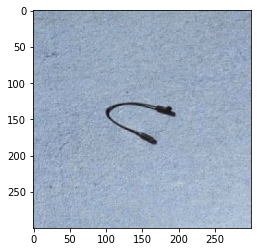

In [36]:
plt.imshow(im)

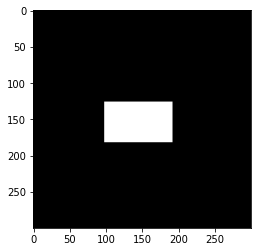

In [37]:
plt.imshow(Y, cmap='gray')

In [38]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


In [39]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [40]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [41]:
df_train.info

<bound method DataFrame.info of                                                 filename width height  class  \
0      /content/drive/MyDrive/Project/Dataset/train_m...   300    300     28   
1      /content/drive/MyDrive/Project/Dataset/train_m...   300    300     28   
2      /content/drive/MyDrive/Project/Dataset/train_m...   300    300     28   
3      /content/drive/MyDrive/Project/Dataset/train_m...   300    300     28   
4      /content/drive/MyDrive/Project/Dataset/train_m...   300    300     28   
...                                                  ...   ...    ...    ...   
24864  /content/drive/MyDrive/Project/Dataset/train_m...   300    300      2   
24865  /content/drive/MyDrive/Project/Dataset/train_m...   300    300      2   
24866  /content/drive/MyDrive/Project/Dataset/train_m...   300    300      2   
24867  /content/drive/MyDrive/Project/Dataset/train_m...   300    300      2   
24868  /content/drive/MyDrive/Project/Dataset/train_m...   300    300      2   

       

In [42]:
df_train.values[0][8]

'/content/drive/MyDrive/Project/Dataset/trained_dataset/032491.jpg'

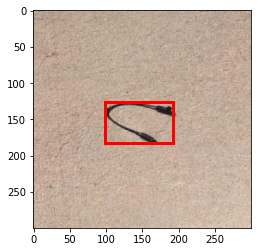

In [43]:
#original
im = cv2.imread(str(df_train.values[58][0]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, [df_train.values[58][5],df_train.values[58][4],df_train.values[58][7],df_train.values[58][6]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


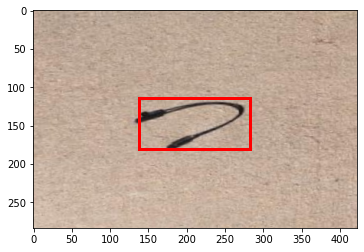

In [44]:
# after transformation
im, bb = transformsXY(str(df_train.values[58][8]),df_train.values[58][9],True)
show_corner_bb(im, bb)

In [45]:
df_train = df_train.reset_index()

## ** SPLIT DATA

In [46]:
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']

In [47]:
X

,new_path,new_bb
0,/content/drive/MyDrive/Project/Dataset/trained...,"[157, 130, 250, 345]"
1,/content/drive/MyDrive/Project/Dataset/trained...,"[155, 132, 245, 341]"
2,/content/drive/MyDrive/Project/Dataset/trained...,"[154, 145, 233, 331]"
3,/content/drive/MyDrive/Project/Dataset/trained...,"[155, 159, 224, 322]"
4,/content/drive/MyDrive/Project/Dataset/trained...,"[155, 165, 221, 319]"
...,...,...
24864,/content/drive/MyDrive/Project/Dataset/trained...,"[160, 212, 187, 226]"
24865,/content/drive/MyDrive/Project/Dataset/trained...,"[162, 212, 189, 228]"
24866,/content/drive/MyDrive/Project/Dataset/trained...,"[164, 214, 190, 228]"
24867,/content/drive/MyDrive/Project/Dataset/trained...,"[165, 215, 191, 229]"


In [48]:
#X.to_csv("/content/drive/MyDrive/data/Xtrain.csv")
#Y.to_csv("/content/drive/MyDrive/data/Ytrain.csv")

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

In [50]:
#X_val.to_csv("/content/drive/MyDrive/Project/Dataset/XValid.csv")
#X_train.to_csv("/content/drive/MyDrive/Project/Dataset/Xtrain.csv")
#y_train.to_csv("/content/drive/MyDrive/Project/Dataset/Ytrain.csv")

In [51]:
#y_val.to_csv("/content/drive/MyDrive/Project/Dataset/YValid.csv")
#df_train2.drop(df_train2.columns[[0,1]], axis=1, inplace=True)
#pd.read_csv("/content/drive/MyDrive/resnet_resized/Upgraded Training.csv")

In [52]:
'''X_train=pd.read_csv("/content/drive/MyDrive/Project/Dataset/Xtrain.csv")
X_train.drop(X_train.columns[[0]], axis=1, inplace=True)
X_val=pd.read_csv("/content/drive/MyDrive/Project/Dataset/XValid.csv")
X_val.drop(X_val.columns[[0]], axis=1, inplace=True)
y_train=pd.read_csv("/content/drive/MyDrive/Project/Dataset/Ytrain.csv")
y_train.drop(y_train.columns[[0]], axis=1, inplace=True)
y_val=pd.read_csv("/content/drive/MyDrive/Project/Dataset/YValid.csv")
y_val.drop(y_val.columns[[0]], axis=1, inplace=True)'''

'X_train=pd.read_csv("/content/drive/MyDrive/Project/Dataset/Xtrain.csv")\nX_train.drop(X_train.columns[[0]], axis=1, inplace=True)\nX_val=pd.read_csv("/content/drive/MyDrive/Project/Dataset/XValid.csv")\nX_val.drop(X_val.columns[[0]], axis=1, inplace=True)\ny_train=pd.read_csv("/content/drive/MyDrive/Project/Dataset/Ytrain.csv")\ny_train.drop(y_train.columns[[0]], axis=1, inplace=True)\ny_val=pd.read_csv("/content/drive/MyDrive/Project/Dataset/YValid.csv")\ny_val.drop(y_val.columns[[0]], axis=1, inplace=True)'

In [53]:
y_val.head()

20822    13
14713     0
6756     20
4679     22
12487     4
Name: class, dtype: int64

In [54]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [55]:
class FOD(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [56]:
train_ds = FOD(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = FOD(X_val['new_path'],X_val['new_bb'],y_val)

In [57]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [58]:
# import the necessary packages
from torch.nn import Dropout
from torch.nn import Identity
from torch.nn import Linear
from torch.nn import Module
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Sigmoid

#Defining Model

In [59]:
class BB_model(nn.Module):
    def __init__(self,backbone):
        super(BB_model, self).__init__()
        self.backbone=backbone
        layers = list(backbone.children())[:-1]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 31))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)


In [60]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [61]:
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure 
from functools import partial
from threading import Thread
from tornado import gen

In [62]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    validation_accuracy=[]
    validation_loss=[]
    training_loss=[]
    Epochs_Total=[]
    evaluation_metrics=[]
    print("Start Training")
    for i in range(epochs):
        Epochs_Total.append(i)
       
        model.train()
       
        total = 0
        sum_loss = 0
       
        for x, y_class, y_bb in train_dl:
            #print("4")
            batch = y_class.shape[0]
            #print("5")
            x = x.cuda().float()
            #print("6")
            y_class = y_class.cuda()
            #print("7")
            y_bb = y_bb.cuda().float()
            #print("8")
            out_class, out_bb = model(x)
            #print("9")
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            #print("10")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            #print("11")
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
            #print("Successful Loop 1")
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        #scheduler.step(val_loss/len(val_dl))
        validation_accuracy.append(val_acc)
        validation_loss.append(val_loss)
        training_loss.append(train_loss)
        #print("Successful Loop 2")
    evaluation_metrics.append(Epochs_Total)
    evaluation_metrics.append(validation_loss)
    evaluation_metrics.append(validation_accuracy)
    evaluation_metrics.append(training_loss)
    return sum_loss/total,evaluation_metrics


In [63]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [65]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

## ** Loading BYOL backbone Model 1

In [66]:
model = BB_model(backbone_BYOL)
model.to(device)
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.1)
#scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)

## ** Training Model

In [67]:
''' !pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()   '''

' !pip install GPUtil\n\nimport torch\nfrom GPUtil import showUtilization as gpu_usage\nfrom numba import cuda\n\ndef free_gpu_cache():\n    print("Initial GPU Usage")\n    gpu_usage()                             \n\n    torch.cuda.empty_cache()\n\n    cuda.select_device(0)\n    cuda.close()\n    cuda.select_device(0)\n\n    print("GPU Usage after emptying the cache")\n    gpu_usage()\n\nfree_gpu_cache()   '

In [68]:
total_loss,evaluation_metrics=train_epocs(model, optimizer, train_dl, valid_dl, epochs=15)

Start Training


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


train_loss 3.698 val_loss 3.693 val_acc 0.211
train_loss 10.015 val_loss 6.005 val_acc 0.097
train_loss 3.269 val_loss 3.748 val_acc 0.287
train_loss 2.201 val_loss 40.537 val_acc 0.271
train_loss 2.099 val_loss 2.929 val_acc 0.466
train_loss 3.728 val_loss 8.314 val_acc 0.412
train_loss 1.683 val_loss 1.161 val_acc 0.733
train_loss 2.457 val_loss 57.064 val_acc 0.248
train_loss 4.579 val_loss 1.422 val_acc 0.824
train_loss 1.037 val_loss 6.925 val_acc 0.856
train_loss 1.833 val_loss 23.137 val_acc 0.405
train_loss 4.809 val_loss 10.387 val_acc 0.745
train_loss 1.367 val_loss 0.559 val_acc 0.926
train_loss 1.139 val_loss 5.336 val_acc 0.825
train_loss 4.700 val_loss 11.471 val_acc 0.888


In [77]:
training_loss=[3.69,10.01,3.2,2.2,2.09,3.7,1.6,2.45,4.57,1.03,1.83,4.80,1.36,1.13,4.70,2.28,2.23,2.30,2.41,2.3]
validation_loss=[3.69,6.0,3.7,40.53,2.929,8.314,1.161,57.064,1.42,6.9,23.13,10.38,0.55,5.33,11.47,12.32,1.87,1.780,4.25,4.53]

In [74]:
update_optimizer(optimizer, 0.001)
total_loss, evaluation_metrics = train_epocs(model, optimizer, train_dl, valid_dl, epochs=5)

Start Training


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


train_loss 2.289 val_loss 12.324 val_acc 0.895
train_loss 2.234 val_loss 1.871 val_acc 0.911
train_loss 2.309 val_loss 1.780 val_acc 0.914
train_loss 2.413 val_loss 4.253 val_acc 0.902
train_loss 2.339 val_loss 4.532 val_acc 0.899


In [78]:
torch.save(model,"/content/drive/MyDrive/Project/Trained_Models/BYOL_Resnet18_3.pth")

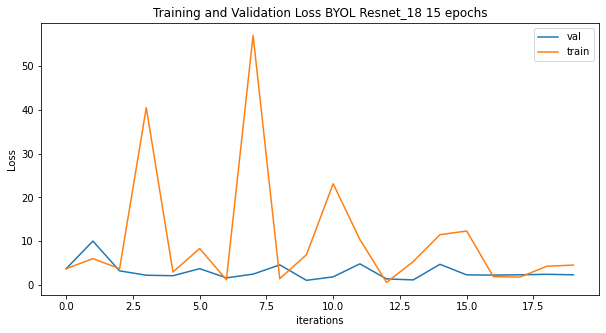

In [79]:
import matplotlib.pyplot as plt



plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss BYOL Resnet_18 15 epochs")
plt.plot(training_loss,label="val")
plt.plot(validation_loss,label="train")
#plt.plot(evaluation_metrics[2],label="val_accuracy")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Testing BYOL

In [80]:
len(X_val)

2487

In [97]:
X_val.loc[20822].at["new_path"]

'/content/drive/MyDrive/Project/Dataset/trained_dataset/005885.jpg'

In [82]:
Validation_Path=[]

In [114]:
Validation_Path[0]

'/content/drive/MyDrive/Project/Dataset/validation_dataset/005885.jpg'

In [ ]:
for i in X_val.index:
  print(i)
  im = read_image(X_val.loc[i].at["new_path"])
  im = cv2.resize(im, (int(1.49*300), 300))
  cv2.imwrite('/content/drive/MyDrive/Project/Dataset/validation_dataset/'+X['new_path'][i][-10:], cv2.cvtColor(im, cv2.COLOR_RGB2BGR))
  Validation_Path.append('/content/drive/MyDrive/Project/Dataset/validation_dataset/'+X['new_path'][i][-10:])

In [103]:
X_val['new_path_test']= Validation_Path

In [115]:
X_val.head()

,new_path,new_bb,new_path_test
20822,/content/drive/MyDrive/Project/Dataset/trained...,"[151, 227, 182, 311]",/content/drive/MyDrive/Project/Dataset/validat...
14713,/content/drive/MyDrive/Project/Dataset/trained...,"[190, 190, 288, 299]",/content/drive/MyDrive/Project/Dataset/validat...
6756,/content/drive/MyDrive/Project/Dataset/trained...,"[68, 130, 271, 293]",/content/drive/MyDrive/Project/Dataset/validat...
4679,/content/drive/MyDrive/Project/Dataset/trained...,"[63, 211, 103, 238]",/content/drive/MyDrive/Project/Dataset/validat...
12487,/content/drive/MyDrive/Project/Dataset/trained...,"[185, 218, 256, 271]",/content/drive/MyDrive/Project/Dataset/validat...


In [116]:
validation_data=FOD(X_val['new_path'],pd.DataFrame(np.zeros((2487, 4))),pd.DataFrame(np.zeros((2487, 1))))
d = pd.DataFrame(np.zeros((2487, 4)))
len(validation_data)

2487

In [188]:
y_predict=[]
bb_predict=[]

In [117]:
validation_data

In [182]:
classes= {0:'AdjustableClamp',1:'AdjustableWrench',2:'Battery',3:'Bolt',4:'BoltNutSet',5:'BoltWasher',6:'ClampPart',7:'Cutter',8:'FuelCap',9:'Hammer',10:'Hose',11:'Label',12:'LuggagePart',13:'LuggageTag',14:'MetalPart',15:'MetalSheet',16:'Nail',17:'Nut',18:'PaintChip',19:'Pen',20:'PlasticPart',21:'Pliers',22:'Rock',23:'Screw',24:'Screwdriver',25:'SodaCan',26:'Tape',27:'Washer', 28:'Wire',29:'Wood',30:'Wrench'}


In [189]:
for i in range (len(validation_data)):
  x, y_class, y_bb = validation_data[i]
  xx = torch.FloatTensor(x[None,])
  out_class, out_bb = model(xx.cuda())
  oclass=torch.max(out_class, 1).indices.detach().cpu().numpy()
  oclass=oclass.astype(int)
  bb_whole=out_bb.detach().cpu().numpy()
  bb_whole = bb_whole.astype(int)
  bb_predict.append(bb_whole[0])
  y_predict.append(classes[oclass[0]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [119]:
# Creating Different Colours
def create_corner_rect_v2(bb, color):
    bb = np.array(bb)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

# Ground vs Predicted Bounding Boxs
def plot_two_rectangle(im,bb1,bb2):
  plt.imshow(im)
  plt.gca().add_patch(create_corner_rect_v2(bb1,color='red'))
  plt.gca().add_patch(create_corner_rect_v2(bb2,color='green'))

In [197]:
IoU=[]

In [190]:
bb_predict[0]

array([136, 187, 176, 223])

In [126]:
X_val[]

,new_path,new_bb,new_path_test
20822,/content/drive/MyDrive/Project/Dataset/trained...,"[151, 227, 182, 311]",/content/drive/MyDrive/Project/Dataset/validat...
14713,/content/drive/MyDrive/Project/Dataset/trained...,"[190, 190, 288, 299]",/content/drive/MyDrive/Project/Dataset/validat...
6756,/content/drive/MyDrive/Project/Dataset/trained...,"[68, 130, 271, 293]",/content/drive/MyDrive/Project/Dataset/validat...
4679,/content/drive/MyDrive/Project/Dataset/trained...,"[63, 211, 103, 238]",/content/drive/MyDrive/Project/Dataset/validat...
12487,/content/drive/MyDrive/Project/Dataset/trained...,"[185, 218, 256, 271]",/content/drive/MyDrive/Project/Dataset/validat...


In [138]:
bb_predict[0][1]

187

In [212]:
j=0
for i in X_val.index:
  ground_truth_bbox = np.array([X_val['new_bb'][i][0],X_val['new_bb'][i][1],X_val['new_bb'][i][2],X_val['new_bb'][i][3]], dtype=np.float32)
  prediction_bbox = np.array([bb_predict[j][0],bb_predict[j][1],bb_predict[j][2],bb_predict[j][3]], dtype=np.float32)
  IoU.append(get_iou(ground_truth_bbox, prediction_bbox))
  j=j+1
[accuracy_list] = [np.array(IoU)]

print(np.mean(accuracy_list))

0.28001533180729704


In [164]:
[accuracy_list] = [np.array(IoU)]

np.mean(accuracy_list)

In [165]:

np.mean(accuracy_list)

0.22247169766971453

In [151]:
y_true=list(y_val)

In [184]:
for i in range(len(y_true)):
  y_true[i]=classes[y_true[i]]

In [192]:
y_predict[0]

'LuggageTag'

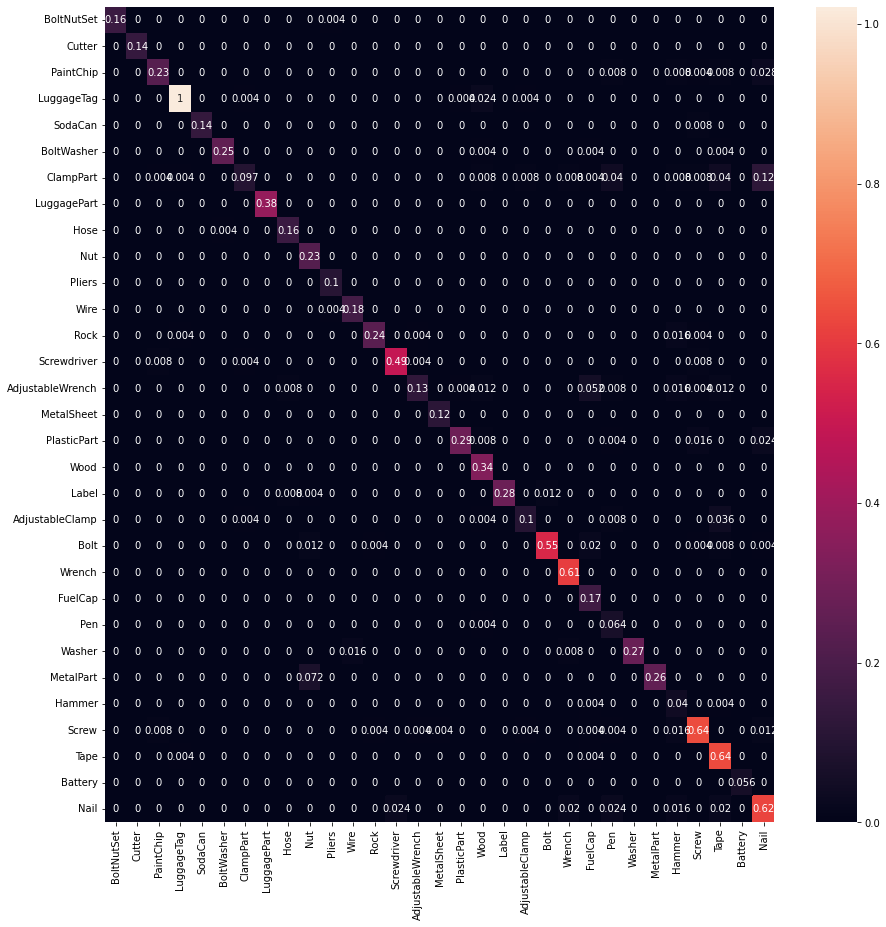

In [213]:
import sklearn.metrics
import seaborn as sn
import pandas as pd



# constant for classes
classes = ('BoltNutSet', 'Cutter', 'PaintChip', 'LuggageTag', 'SodaCan', 'BoltWasher', 'ClampPart', 'LuggagePart', 'Hose', 'Nut', 'Pliers', 'Wire', 'Rock', 'Screwdriver', 'AdjustableWrench', 'MetalSheet', 'PlasticPart', 'Wood', 'Label', 'AdjustableClamp', 'Bolt', 'Wrench', 'FuelCap', 'Pen', 'Washer', 'MetalPart', 'Hammer', 'Screw', 'Tape', 'Battery', 'Nail')

# Build confusion matrix
cf_matrix = sklearn.metrics.confusion_matrix(y_true, y_predict)
#print(cf_matrix)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (15,15))
sn.heatmap(df_cm, annot=True)
plt.savefig('BYOL_modeloutput 8k.png')

In [214]:
#print accuracy of model
print(sklearn.metrics.accuracy_score(y_true, y_predict))

#print precision value of model
print(sklearn.metrics.precision_score(y_true, y_predict,average='weighted'))

#print recall value of model
print(sklearn.metrics.recall_score(y_true, y_predict,average='macro'))

0.8990751909931645
0.9161350743369336
0.8972358276579857


In [210]:
r = sklearn.metrics.multilabel_confusion_matrix(y_true, y_predict, labels=['BoltNutSet', 'Cutter', 'PaintChip', 'LuggageTag', 'SodaCan', 'BoltWasher', 'ClampPart', 'LuggagePart', 'Hose', 'Nut', 'Pliers', 'Wire', 'Rock', 'Screwdriver', 'AdjustableWrench', 'MetalSheet', 'PlasticPart', 'Wood', 'Label', 'AdjustableClamp', 'Bolt', 'Wrench', 'FuelCap', 'Pen', 'Washer', 'MetalPart', 'Hammer', 'Screw', 'Tape', 'Battery', 'Nail'])
print(r[0])

[[2450    0]
 [   2   35]]


In [ ]:
labels=[]

In [ ]:
'''for i in range(9):
  x=[20822,14713,6756,4679,12487,24664,12371,23226,4186]
  im=read_image(X_val.loc[x[i]].at["new_path"])
  ground_truth_bbox = np.array([X_val['new_bb'][x[i]][0],X_val['new_bb'][x[i]][1],X_val['new_bb'][x[i]][2],X_val['new_bb'][x[i]][3]], dtype=np.float32)
  prediction_bbox = np.array([bb_predict[i][0],bb_predict[i][1],bb_predict[i][2],bb_predict[i][3]], dtype=np.float32)
  plot_two_rectangle(im,ground_truth_bbox,prediction_bbox)'''

## ** Loading Resnet_18

In [205]:
model2 = torch.load("/content/drive/MyDrive/Models_8k/Resnet18.pth")

In [ ]:
#total_loss,evaluation_metrics=train_epocs(model2, optimizer,train_dl, valid_dl, epochs=15)
#torch.save(model2,"/content/drive/MyDrive/Project/Trained_Models/Resnet18_2.pth")

In [206]:
y_predictR18=[]
bb_predictR18=[]
for i in range (len(validation_data)):
  x, y_class, y_bb = validation_data[i]
  xx = torch.FloatTensor(x[None,])
  out_class, out_bb = model2(xx.cuda())
  oclass=torch.max(out_class, 1).indices.detach().cpu().numpy()
  oclass=oclass.astype(int)
  bb_whole=out_bb.detach().cpu().numpy()
  bb_whole = bb_whole.astype(int)
  bb_predictR18.append(bb_whole[0])
  y_predictR18.append(classes[oclass[0]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [207]:
j=0
for i in X_val.index:
  ground_truth_bbox = np.array([X_val['new_bb'][i][0],X_val['new_bb'][i][1],X_val['new_bb'][i][2],X_val['new_bb'][i][3]], dtype=np.float32)
  prediction_bbox = np.array([bb_predictR18[j][0],bb_predictR18[j][1],bb_predictR18[j][2],bb_predictR18[j][3]], dtype=np.float32)
  IoU.append(get_iou(ground_truth_bbox, prediction_bbox))
  j=j+1
[accuracy_list] = [np.array(IoU)]

np.mean(accuracy_list)

0.29484300809218494

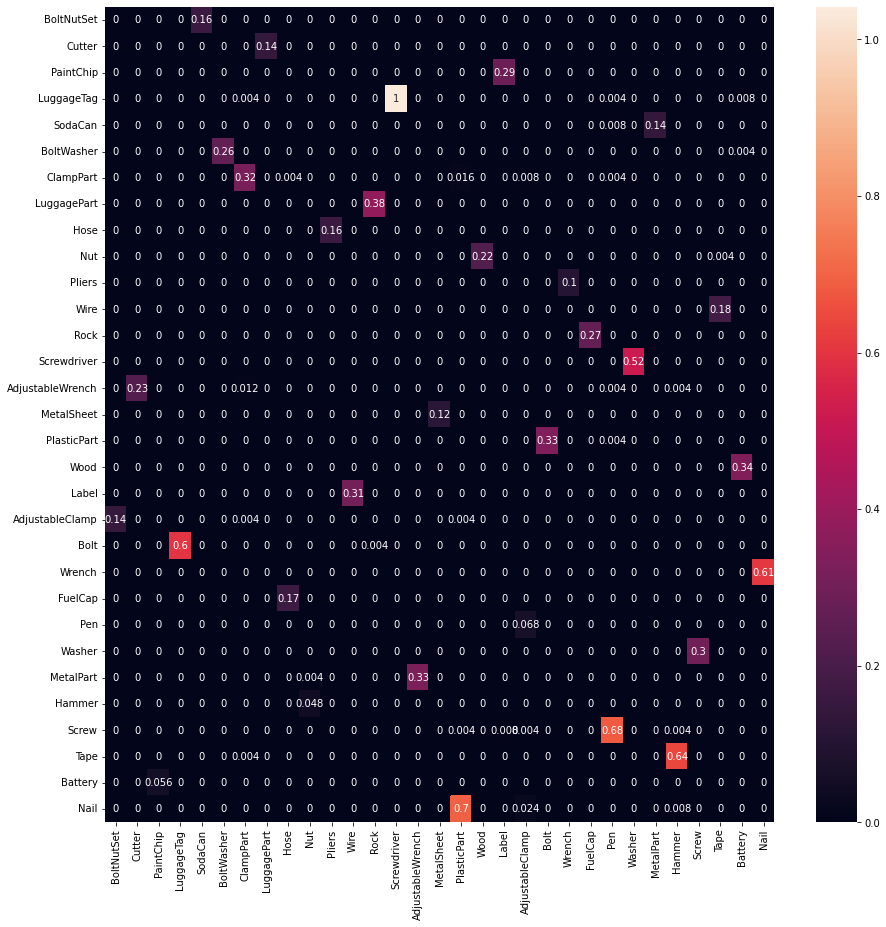

In [208]:
import sklearn.metrics
import seaborn as sn
import pandas as pd



# constant for classes
classes = ('BoltNutSet', 'Cutter', 'PaintChip', 'LuggageTag', 'SodaCan', 'BoltWasher', 'ClampPart', 'LuggagePart', 'Hose', 'Nut', 'Pliers', 'Wire', 'Rock', 'Screwdriver', 'AdjustableWrench', 'MetalSheet', 'PlasticPart', 'Wood', 'Label', 'AdjustableClamp', 'Bolt', 'Wrench', 'FuelCap', 'Pen', 'Washer', 'MetalPart', 'Hammer', 'Screw', 'Tape', 'Battery', 'Nail')

# Build confusion matrix
cf_matrix = sklearn.metrics.confusion_matrix(y_true, y_predictR18)
#print(cf_matrix)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (15,15))
sn.heatmap(df_cm, annot=True)
plt.savefig('BYOL_modeloutput 8k.png')

In [209]:
#print accuracy of model
print(sklearn.metrics.accuracy_score(y_true, y_predictR18))

#print precision value of model
print(sklearn.metrics.precision_score(y_true, y_predictR18,average='weighted'))

#print recall value of model
print(sklearn.metrics.recall_score(y_true, y_predictR18,average='macro'))

0.06956172094893445
0.0707112277963055
0.09331917618903159


In [ ]:
import matplotlib.pyplot as plt



plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss Resnet_18")
plt.plot(evaluation_metrics[1],label="val")
plt.plot(evaluation_metrics[3],label="train")
#plt.plot(evaluation_metrics[2],label="val_accuracy")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## ** Loadin Resnet_34

In [176]:
model3 = BB_model(resnet34)
model3.to(device)
parameters = filter(lambda p: p.requires_grad, model3.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.06)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)

In [177]:
total_loss,evaluation_metrics=train_epocs(model3, optimizer,train_dl, valid_dl, epochs=15)

Start Training


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


train_loss 3.201 val_loss 2.836 val_acc 0.275
train_loss 2.397 val_loss 6.608 val_acc 0.218
train_loss 2.085 val_loss 3.305 val_acc 0.422
train_loss 1.608 val_loss 13.401 val_acc 0.171
train_loss 1.540 val_loss 0.755 val_acc 0.827
train_loss 0.693 val_loss 0.940 val_acc 0.808
train_loss 2.220 val_loss 7.943 val_acc 0.554
train_loss 1.120 val_loss 0.363 val_acc 0.926
train_loss 0.458 val_loss 0.267 val_acc 0.946
train_loss 1.381 val_loss 8.047 val_acc 0.613
train_loss 1.304 val_loss 0.509 val_acc 0.931
train_loss 0.483 val_loss 0.980 val_acc 0.896
train_loss 2.205 val_loss 5.140 val_acc 0.779
train_loss 0.680 val_loss 0.518 val_acc 0.951
train_loss 0.483 val_loss 0.404 val_acc 0.941


In [178]:
torch.save(model3,"/content/drive/MyDrive/Project/Trained_Models/Resnet34_2.pth")

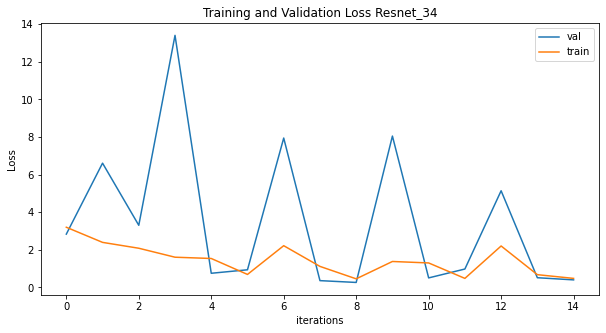

In [179]:
import matplotlib.pyplot as plt



plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss Resnet_34")
plt.plot(evaluation_metrics[1],label="val")
plt.plot(evaluation_metrics[3],label="train")
#plt.plot(evaluation_metrics[2],label="val_accuracy")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [200]:
y_predictR34=[]
bb_predictR34=[]
for i in range (len(validation_data)):
  x, y_class, y_bb = validation_data[i]
  xx = torch.FloatTensor(x[None,])
  out_class, out_bb = model3(xx.cuda())
  oclass=torch.max(out_class, 1).indices.detach().cpu().numpy()
  oclass=oclass.astype(int)
  bb_whole=out_bb.detach().cpu().numpy()
  bb_whole = bb_whole.astype(int)
  bb_predictR34.append(bb_whole[0])
  y_predictR34.append(classes[oclass[0]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [211]:
j=0
for i in X_val.index:
  ground_truth_bbox = np.array([X_val['new_bb'][i][0],X_val['new_bb'][i][1],X_val['new_bb'][i][2],X_val['new_bb'][i][3]], dtype=np.float32)
  prediction_bbox = np.array([bb_predictR34[j][0],bb_predictR34[j][1],bb_predictR34[j][2],bb_predictR34[j][3]], dtype=np.float32)
  IoU.append(get_iou(ground_truth_bbox, prediction_bbox))
  j=j+1
[accuracy_list] = [np.array(IoU)]

print(np.mean(accuracy_list))

0.2991965431864912


0.22247169766971453

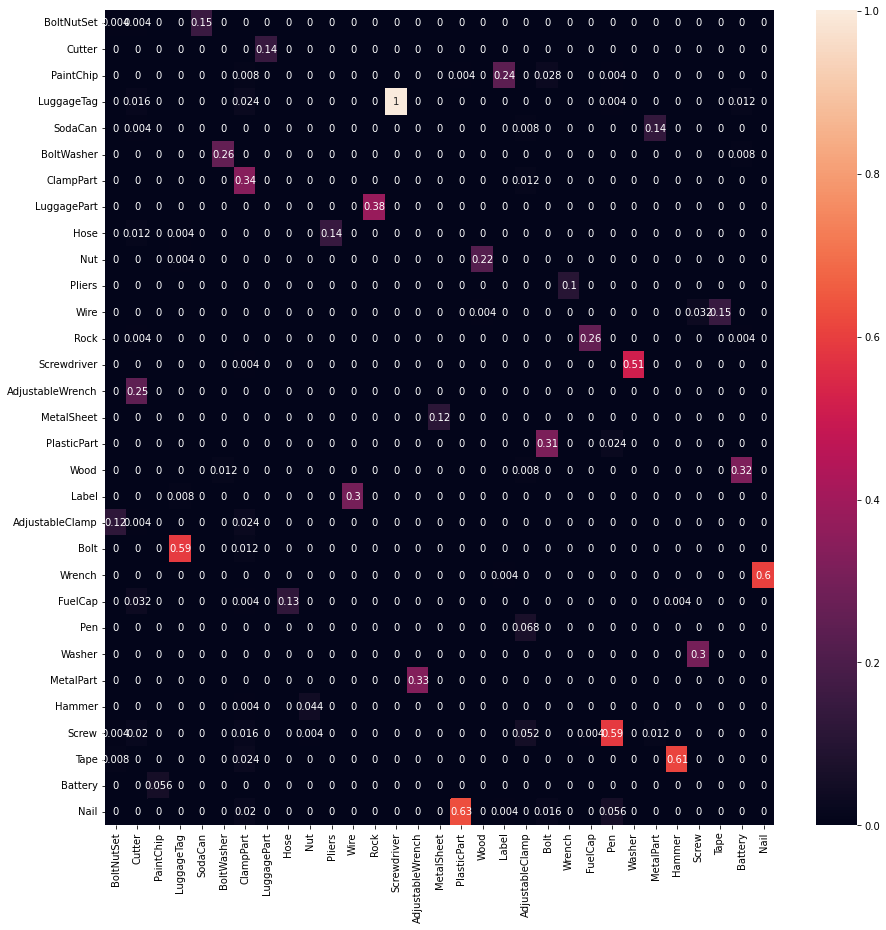

In [203]:
import sklearn.metrics
import seaborn as sn
import pandas as pd



# constant for classes
classes = ('BoltNutSet', 'Cutter', 'PaintChip', 'LuggageTag', 'SodaCan', 'BoltWasher', 'ClampPart', 'LuggagePart', 'Hose', 'Nut', 'Pliers', 'Wire', 'Rock', 'Screwdriver', 'AdjustableWrench', 'MetalSheet', 'PlasticPart', 'Wood', 'Label', 'AdjustableClamp', 'Bolt', 'Wrench', 'FuelCap', 'Pen', 'Washer', 'MetalPart', 'Hammer', 'Screw', 'Tape', 'Battery', 'Nail')

# Build confusion matrix
cf_matrix = sklearn.metrics.confusion_matrix(y_true, y_predictR34)
#print(cf_matrix)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (15,15))
sn.heatmap(df_cm, annot=True)
plt.savefig('BYOL_modeloutput 8k.png')

In [204]:
#print accuracy of model
print(sklearn.metrics.accuracy_score(y_true, y_predictR34))

#print precision value of model
print(sklearn.metrics.precision_score(y_true, y_predictR34,average='weighted'))

#print recall value of model
print(sklearn.metrics.recall_score(y_true, y_predictR34,average='macro'))

0.07157217531162043
0.06216300682273521
0.09549078100246065


## ** Testing Model

In [171]:
X_val['new_path'][23316][-10:]

'001243.jpg'

In [ ]:
''' 22160
23316
12133
16292 '''

In [ ]:
X_val.head()

In [ ]:
# resizing test image and passing it to new test folder
im = read_image(X_val['new_path'][712])
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('/content/drive/MyDrive/test/'+X_val['new_path'][712][-10:], cv2.cvtColor(im, cv2.COLOR_RGB2BGR))
test_ds = FOD(pd.DataFrame([{'path':X_val['new_path'][23316]}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

In [173]:
x, y_class, y_bb = test_ds[0]
xx = torch.FloatTensor(x[None,])
xx.shape
# prediction
out_class, out_bb = model(xx.cuda())
print(out_class)
# predicted class
torch.max(out_class, 1)

tensor([[ -93.6175, -179.8064,   50.2074,   44.1309,  -63.5040,  126.0487,
           50.6609,    4.8975,   52.5165,  -92.0480, -120.5124,  -94.1465,
           72.9205,  -81.6616,   62.6629,  -72.4762,   46.7182,   98.7231,
          -86.0074,   35.0595,    1.9562,  -19.0847,   57.1513,   74.6459,
          -66.1886, -117.1043,   12.4489,   53.3087,   54.7891, -126.0062,
           66.6529]], device='cuda:0', grad_fn=<AddmmBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


torch.return_types.max(
values=tensor([126.0487], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([5], device='cuda:0'))

array([123, 156, 176, 231])

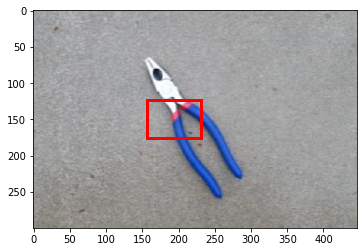

In [174]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])
bb_hat[0]

In [ ]:
# Drawing bounding box from actual
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, X_val['new_bb'][1385])

In [ ]:
# Creating Different Colours
def create_corner_rect_v2(bb, color):
    bb = np.array(bb)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

# Ground vs Predicted Bounding Boxs
def plot_two_rectangle(im,bb1,bb2):
  plt.imshow(im)
  plt.gca().add_patch(create_corner_rect_v2(bb1,color='red'))
  plt.gca().add_patch(create_corner_rect_v2(bb2,color='green'))

In [ ]:
Y_val_read = pd.read_csv('/content/drive/MyDrive/data_8k/YVal.csv')

In [ ]:
Y_val_read

## ** Defining Testing Metrics

In [121]:
# Defining IOU
def get_iou(ground_truth, pred):
    # coordinates of the area of intersection.
    ix1 = np.maximum(ground_truth[0], pred[0])
    iy1 = np.maximum(ground_truth[1], pred[1])
    ix2 = np.minimum(ground_truth[2], pred[2])
    iy2 = np.minimum(ground_truth[3], pred[3])
    
    # Intersection height and width.
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))
    
    area_of_intersection = i_height * i_width
    
    # Ground Truth dimensions.
    gt_height = ground_truth[3] - ground_truth[1] + 1
    gt_width = ground_truth[2] - ground_truth[0] + 1
    
    # Prediction dimensions.
    pd_height = pred[3] - pred[1] + 1
    pd_width = pred[2] - pred[0] + 1
    
    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection
    
    iou = area_of_intersection / area_of_union
    
    return iou

In [76]:
ground_truth_bbox = np.array([X_val['new_bb'][1385][0],X_val['new_bb'][1385][1],X_val['new_bb'][1385][2],X_val['new_bb'][1385][3]], dtype=np.float32)

prediction_bbox = np.array([bb_hat[0][0],bb_hat[0][1],bb_hat[0][2],bb_hat[0][3]], dtype=np.float32)

KeyError: ignored

In [ ]:
iou = get_iou(ground_truth_bbox, prediction_bbox)
print('IOU: ', iou)

In [ ]:
# Import dependencies.
plot_two_rectangle(im,ground_truth_bbox,prediction_bbox)

In [ ]:
#Defining Confusion Matrix


## ** Saving Model

In [ ]:
#torch.save(model,"/content/drive/MyDrive/Models/Resnet18.h5")